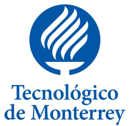

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
### Tecnológico de Monterrey
###  	Dr. David Antonio Torres

#### **Actividad 4.2 - Ejercicio de clasificación con Keras**
____


**Nombres y matrículas de los integrantes del equipo:**

*   Julio Cesar Lynn Jimenez A01793660
*   Francisco Javier Parga García A01794380
*   Carlos Roberto Torres Ferguson A01215432
*   Fernando Sebastian Sanchez Cardona A01687530

____